<a href="https://colab.research.google.com/github/Amal-Alalami/Projects-CV/blob/main/CNN_CLAHE(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# to generate data
from keras.preprocessing.image import ImageDataGenerator

# to build model
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
%matplotlib inline

# Upload Dataset

In [ ]:
!7z x archive.zip



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 35779075 bytes (35 MiB)

Extracting archive: archive.zip
 64% 4096 Open              --
Path = archive.zip
Type = zip
Physical Size = 35779075

  0%     11% 807 - Alzheimer_s Dataset/test/NonDemented/32 (79).jpg                                                            23% 1600 - Alzheimer_s Dataset/train/MildDemented/mildDem388.jpg                                                                  35% 2304 - Alzheimer_s Dataset/train/Non

# **Pre-processed data and Visualize Sample Images**

In [ ]:
# Method to print sample images from each class

def print_sample_images(train_path, class_labels):

  plt.figure(figsize=(10, 10))
  for i, class_name in enumerate(class_labels):

    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_path, class_name)))
    img_path = os.path.join(train_path, class_name, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

  plt.show()

**Sample of train images before pre-processing data from each class**

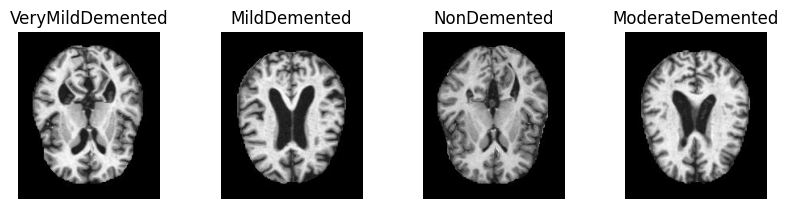

In [ ]:
train_dir = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
print_sample_images(train_dir, class_names)

**Pre-processing data**

In [ ]:
def process_images_in_folder(folder_path):
  width, height = 128, 128

  for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    image = cv2.imread(image_path)

    #resizes data
    #image = image.resize(image, (width, height))
    #image = image / 255.0 #normalize
    #image = image.reshape(1, (width, height), 1)

    #pre-processing data using ABF (Adaptive Bilateral filter) and Contrast Limited Adaptive Histogram Equalization (CLAHE)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #bilateral = cv2.bilateralFilter(gray_image, 15, 75, 75)
    clahe = cv2.createCLAHE(clipLimit=1)
    preprocessed_image = clahe.apply(gray_image)

    # Save the pre-processed image with the same filename
    cv2.imwrite(image_path, preprocessed_image)

In [ ]:
train_data_path = '/content/Alzheimer_s Dataset/train'
test_data_path = '/content/Alzheimer_s Dataset/test'
class_labels = os.listdir('/content/Alzheimer_s Dataset/train')


def data_to_be_processed(class_path ,class_labels):
  for class_label in class_labels:
    class_folder_path = os.path.join(class_path, class_label)
    process_images_in_folder(class_folder_path)



# train data
data_to_be_processed(train_data_path, class_labels)

# test data
data_to_be_processed(test_data_path, class_labels)

**Sample of train images after pre-processing data from each class**

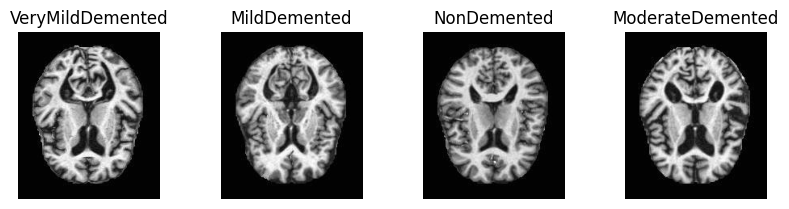

In [ ]:
train_dir = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
print_sample_images(train_dir, class_names)

# Images in train data

In [ ]:
train_folder = '/content/Alzheimer_s Dataset/train'
class_names_train_folder = os.listdir(train_folder)
class_count = []

for class_name in class_names_train_folder:
  num_images = len(os.listdir(os.path.join(train_folder, class_name)))
  class_count.append(num_images)
  print(f"Class {class_name}: {num_images} images")


Class VeryMildDemented: 1792 images
Class MildDemented: 717 images
Class NonDemented: 2560 images
Class ModerateDemented: 52 images


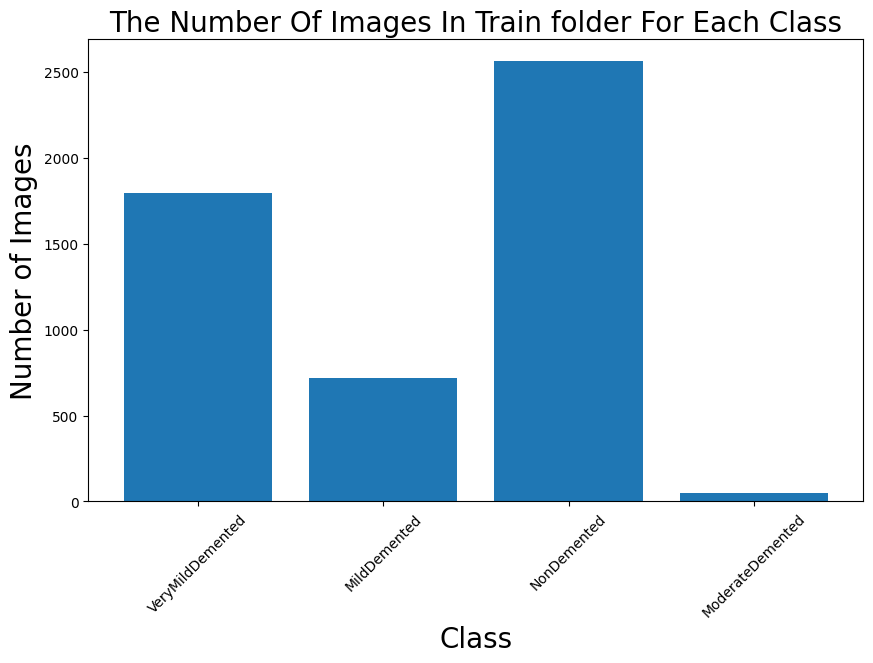

In [ ]:

plt.figure(figsize=(10, 6))
plt.bar(class_names_train_folder, class_count)

plt.title('The Number Of Images In Train folder For Each Class', fontsize=20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Images", fontsize=20)
plt.xticks(rotation=45)

plt.show()


# **Train Test split and Build Model**

In [ ]:
#  Loads all images and labels from a directory and converts them to a NumPy array.

def load_train_data(data_dir):

  image_width, image_height = 128, 128
  class_names = os.listdir(data_dir)
  class_name_to_label = {class_name: i for i, class_name in enumerate(class_names)}
  images = []
  labels = []

  for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):

      image_path = os.path.join(class_path, filename)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      image = cv2.resize(image, (image_width, image_height))
      image = image / 255.0 #normalize

      label = class_name_to_label[class_name]
      images.append(image)
      labels.append(label)

  # Convert the list of images to a NumPy array
  X_train = np.asarray(images)
  Y_train = np.asarray(labels)

  return X_train, Y_train

In [ ]:
X_train , Y_train = load_train_data('/content/Alzheimer_s Dataset/train')

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train shape: (5121, 128, 128)
Y_train shape: (5121,)


In [ ]:
Y_train

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
Y_train = tf.keras.utils.to_categorical(Y_train)

In [ ]:
Y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
print(Y_train.shape)

(5121, 4)


In [ ]:
X_test , Y_test = load_train_data('/content/Alzheimer_s Dataset/test')

In [ ]:
print(f"X_test original shape: {X_test.shape}")
print(f"Y_test original shape: {Y_test.shape}")

X_test original shape: (1279, 128, 128)
Y_test original shape: (1279,)


In [ ]:
X_val, X_test, Y_val , Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

In [ ]:
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_test shape: (1279, 128, 128)
Y_test shape: (1279,)


In [ ]:
print(f"X_validation shape: {X_val.shape}")
print(f"Y_validation shape: {Y_val.shape}")

X_validation shape: (639, 128, 128)
Y_validation shape: (639, 4, 2)


In [ ]:
Y_val

array([1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 0, 0, 0, 0,
       2, 1, 2, 2, 2, 2, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 2, 2, 1, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 0, 2, 2, 0, 1, 2,
       2, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2,
       1, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       0, 1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 0, 1, 1, 2, 0,
       2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2,
       2, 3, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 1, 2, 2, 3, 0, 0, 2, 0, 2,
       2, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0,
       2, 0, 0, 2, 0, 0, 2, 3, 2, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0,
       2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2,
       2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0,

In [ ]:
Y_val = tf.keras.utils.to_categorical(Y_val)

In [ ]:
Y_val

array([[[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       ...,

       [[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]]], dtype=float32)

In [ ]:
print(Y_val.shape)

(639, 4, 2)


In [ ]:
Y_test

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
Y_test_cat = tf.keras.utils.to_categorical(Y_test)

In [ ]:
print(Y_test_cat.shape)

(1279, 4)


In [ ]:
Y_test_cat

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
# CNN model
model1 = Sequential()
inputSize = (128,128,1)

#ilters=32, kernel_size=(4,4), input_shape=(28,28,1), activation='relu')
model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Flatten())

model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(4, activation = 'softmax'))
model1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0

In [ ]:
results = model1.fit(X_train, Y_train, epochs=35)

Epoch 1/35
161/161 [==============================] - 96s 595ms/step - loss: 0.7502 - accuracy: 0.6690
Epoch 2/35
161/161 [==============================] - 89s 551ms/step - loss: 0.4775 - accuracy: 0.8034
Epoch 3/35
161/161 [==============================] - 92s 572ms/step - loss: 0.2378 - accuracy: 0.9092
Epoch 4/35
161/161 [==============================] - 89s 553ms/step - loss: 0.1171 - accuracy: 0.9561
Epoch 5/35
161/161 [==============================] - 90s 558ms/step - loss: 0.0471 - accuracy: 0.9861
Epoch 6/35
161/161 [==============================] - 91s 563ms/step - loss: 0.0265 - accuracy: 0.9930
Epoch 7/35
161/161 [==============================] - 90s 561ms/step - loss: 0.0433 - accuracy: 0.9852
Epoch 8/35
161/161 [==============================] - 97s 601ms/step - loss: 0.0297 - accuracy: 0.9904
Epoch 9/35
161/161 [==============================] - 89s 553ms/step - loss: 0.0362 - accuracy: 0.9875
Epoch 10/35
161/161 [==============================] - 90s 554ms/step - l

In [ ]:
print(model1.output_shape)

(None, 4)


In [ ]:
hist_=pd.DataFrame(results.history)
hist_

,loss,accuracy
0,0.750218,0.669010
1,0.477471,0.803359
2,0.237755,0.909197
3,0.117076,0.956063
4,0.047061,0.986136
5,0.026539,0.992970
6,0.043253,0.985159
7,0.029710,0.990432
8,0.036247,0.987502
9,0.025107,0.990822


# **Model Evaluation**

In [ ]:
loss, acc = model1.evaluate(X_test, Y_test_cat)
print('loss: ', loss)
print('accuracy ', acc)

40/40 [==============================] - 6s 151ms/step - loss: 3.5147 - accuracy: 0.6169
loss:  3.514707326889038
accuracy  0.616888165473938


In [ ]:
# Reshape Y_test to a 1-dimensional array
Y_test = Y_test.reshape(-1,)

predictions = model1.predict(X_test)
Y_predected = np.argmax(predictions, axis=1)
#Y_test_ = np.argmax(Y_test,axis=0)

df = pd.DataFrame({'Actual': Y_test, 'Prediction': Y_predected})
df

40/40 [==============================] - 6s 141ms/step


,Actual,Prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1274,3,3
1275,3,0
1276,3,0
1277,3,0


In [ ]:
#Y_test = Y_test.reshape(-1, 1)

In [ ]:
'''CM = confusion_matrix(Y_test,Y_predected)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM'''

"CM = confusion_matrix(Y_test,Y_predected)\nCM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]\n\nsns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')\nCM"

In [ ]:
print(classification_report(Y_test, Y_predected))

              precision    recall  f1-score   support

           0       0.50      0.87      0.64       448
           1       0.61      0.45      0.52       179
           2       0.85      0.49      0.62       640
           3       1.00      0.17      0.29        12

    accuracy                           0.62      1279
   macro avg       0.74      0.50      0.52      1279
weighted avg       0.70      0.62      0.61      1279

